In [1]:
import json
import re 
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, SimpleRNN

stopwords = stopwords.words("english")


#Modelling
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
# Dataset: https://www.kaggle.com/datasets/debarshichanda/goemotions
train_data = pd.read_csv(r"GoEmotions_Train.tsv", sep="\t", header=None, names=["Comment", "Class", "Delete"])
test_data = pd.read_csv(r"GoEmotions_Test.tsv", sep="\t", header=None, names=["Comment", "Class", "Delete"])
val_data = pd.read_csv(r"GoEmotions_Dev.tsv", sep="\t", header=None, names=["Comment", "Class", "Delete"])

In [3]:
train_data = train_data.drop("Delete", axis=1)
test_data = test_data.drop("Delete", axis=1)
val_data = val_data.drop("Delete", axis=1)

In [4]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(43410, 2)
(5427, 2)
(5426, 2)


In [5]:
train_data.head()

Comment Class
0  My favourite food is anything I didn't have to...    27
1  Now if he does off himself, everyone will thin...    27
2                     WHY THE FUCK IS BAYLESS ISOING     2
3                        To make her feel threatened    14
4                             Dirty Southern Wankers     3

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  43410 non-null  object
 1   Class    43410 non-null  object
dtypes: object(2)
memory usage: 678.4+ KB


# Data Preprocessing

In [7]:
train_data["Class list"] = train_data["Class"].apply(lambda x: x.split(","))
train_data["Class len"] = train_data["Class list"].apply(lambda x: len(x))

test_data["Class list"] = test_data["Class"].apply(lambda x: x.split(","))
test_data["Class len"] = test_data["Class list"].apply(lambda x: len(x))

val_data["Class list"] = val_data["Class"].apply(lambda x: x.split(","))
val_data["Class len"] = val_data["Class list"].apply(lambda x: len(x))

In [8]:
with open(r"D:\Drive D Documents\Mafaz\Academic\School\University\Sheffield University\MSc\Robotics\Modules\Semester 2\Thesis\Dissertation\TER\goemotions\data\ekman_mapping.json") as file:
    ekman_mapping = json.load(file)

In [9]:
emotion_file = open(r"D:\Drive D Documents\Mafaz\Academic\School\University\Sheffield University\MSc\Robotics\Modules\Semester 2\Thesis\Dissertation\TER\goemotions\data\emotions.txt")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)
print(len(emotion_list))

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
28


In [10]:
def idx2class(idxlist):
    arr = []
    for i in idxlist:
        arr.append(emotion_list[int(i)])
    return arr

In [11]:
# Converting the class indexes back to class names
train_data["Emotion"] = train_data["Class list"].apply(idx2class)
test_data["Emotion"] = test_data["Class list"].apply(idx2class)
val_data["Emotion"] = val_data["Class list"].apply(idx2class)

In [12]:
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping["anger"]:
            map_list.append("anger")
        if i in ekman_mapping["disgust"]:
            map_list.append("disgust")
        if i in ekman_mapping["fear"]:
            map_list.append("fear")
        if i in ekman_mapping["joy"]:
            map_list.append("joy")
        if i in ekman_mapping["sadness"]:
            map_list.append("sadness")
        if i in ekman_mapping["surprise"]:
            map_list.append("surprise")
        if i == "neutral":
            map_list.append("neutral")
            
    return map_list

In [13]:
# Convert the classes based on Ekman Taxonomy
train_data["Mapped_emotion"] = train_data["Emotion"].apply(EmotionMapping)
test_data["Mapped_emotion"] = test_data["Emotion"].apply(EmotionMapping)
val_data["Mapped_emotion"] = val_data["Emotion"].apply(EmotionMapping)

In [14]:
train_data["Mapped_emotion"] = train_data["Mapped_emotion"].apply(lambda x: ','.join(x))
test_data["Mapped_emotion"] = test_data["Mapped_emotion"].apply(lambda x: ','.join(x))
val_data["Mapped_emotion"] = val_data["Mapped_emotion"].apply(lambda x: ','.join(x))

In [15]:
train_data = train_data.drop(["Class", "Class list", "Class len", "Emotion"], axis=1)
test_data = test_data.drop(["Class", "Class list", "Class len", "Emotion"], axis=1)
val_data = val_data.drop(["Class", "Class list", "Class len", "Emotion"], axis=1)

In [16]:
train_data_1= train_data["Mapped_emotion"].str.split(",", expand=True)
test_data_1= test_data["Mapped_emotion"].str.split(",", expand=True)
val_data_1= val_data["Mapped_emotion"].str.split(",", expand=True)

In [17]:
train_data_1.drop(train_data_1.columns[1:5], axis=1, inplace=True)
test_data_1.drop(test_data_1.columns[1:5], axis=1, inplace=True)
val_data_1.drop(val_data_1.columns[1:5], axis=1, inplace=True)

In [18]:
train_data = pd.concat([train_data, train_data_1], axis=1)
test_data = pd.concat([test_data, test_data_1], axis=1)
val_data = pd.concat([val_data, val_data_1], axis=1)

In [19]:
train_data.rename(columns={0: "Emotion"}, inplace=True)
test_data.rename(columns={0: "Emotion"}, inplace=True)
val_data.rename(columns={0: "Emotion"}, inplace=True)

In [20]:
train_data = train_data.drop(["Mapped_emotion"], axis=1)
test_data = test_data.drop(["Mapped_emotion"], axis=1)
val_data = val_data.drop(["Mapped_emotion"], axis=1)

In [21]:
#Checking if the data is balanced or not
train_data.Emotion.value_counts()

Emotion
joy         16948
neutral     12823
anger        5336
surprise     4489
sadness      2619
fear          615
disgust       580
Name: count, dtype: int64

# Word Cloud

In [22]:
emotion_list = train_data["Emotion"].unique()
emotion_list

array(['neutral', 'anger', 'fear', 'surprise', 'joy', 'sadness',
       'disgust'], dtype=object)

In [23]:
def word_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.suptitle(df + " Word Cloud", size=15)
    plt.imshow(wordcloud)
    plt.axis("off")

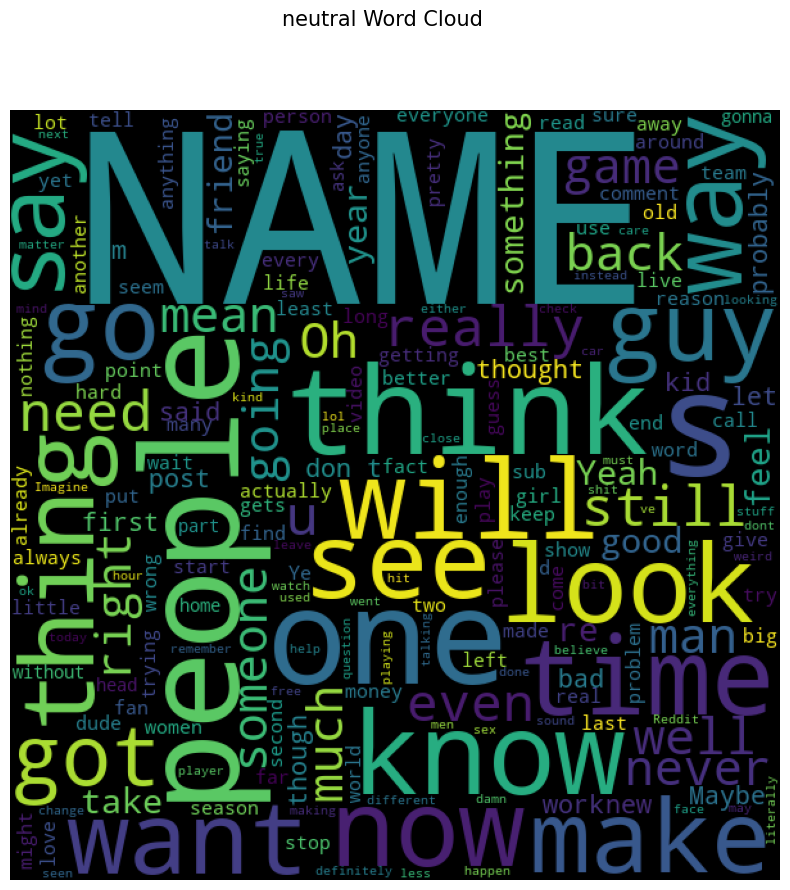

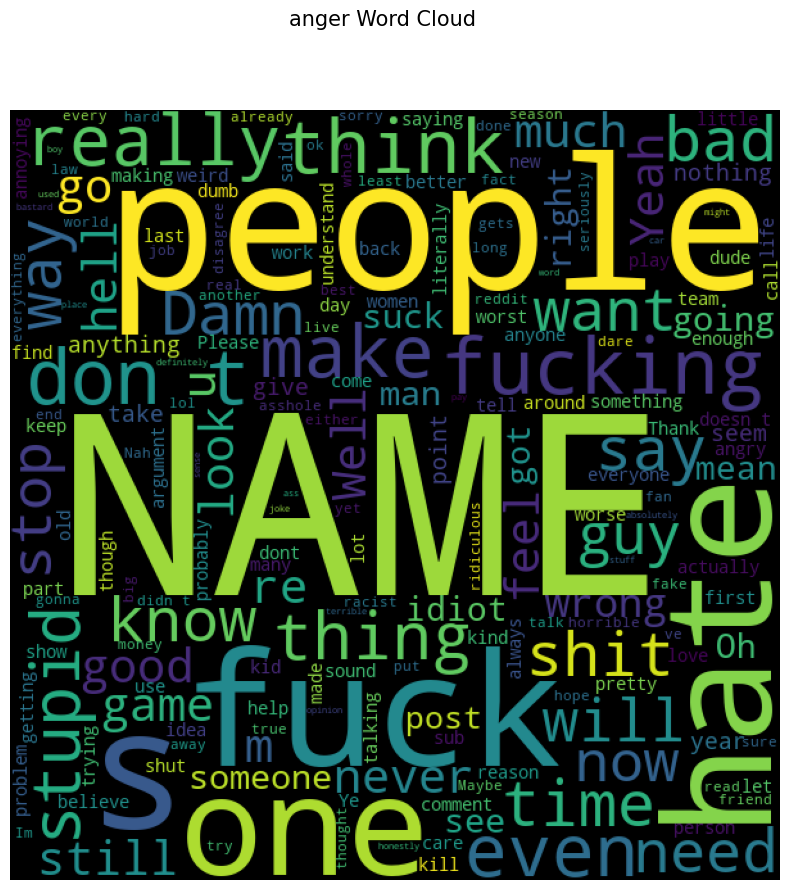

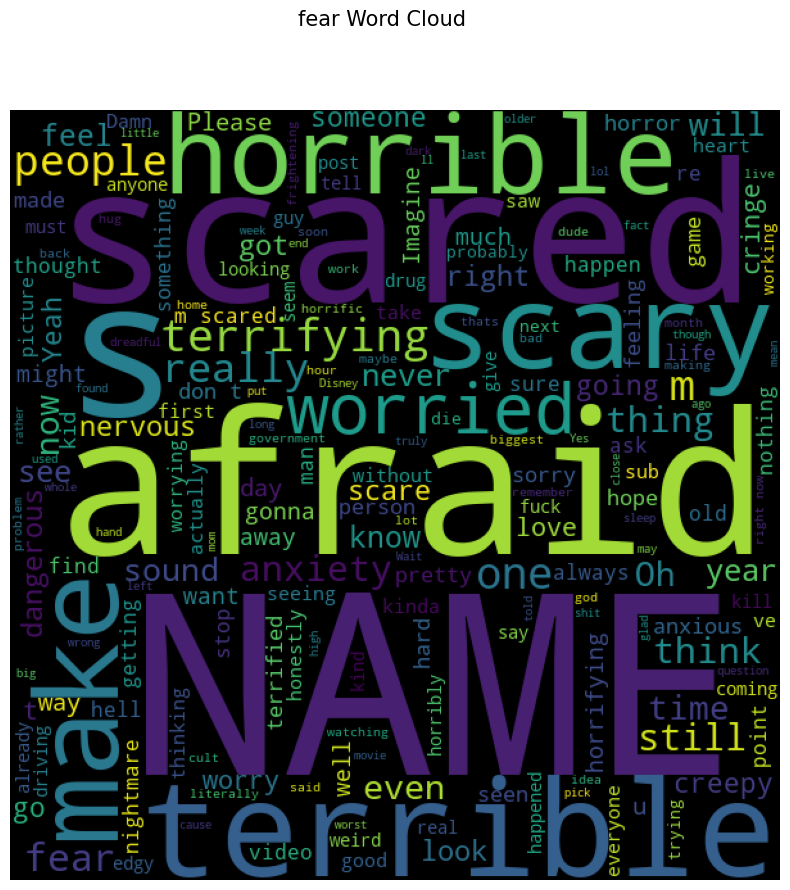

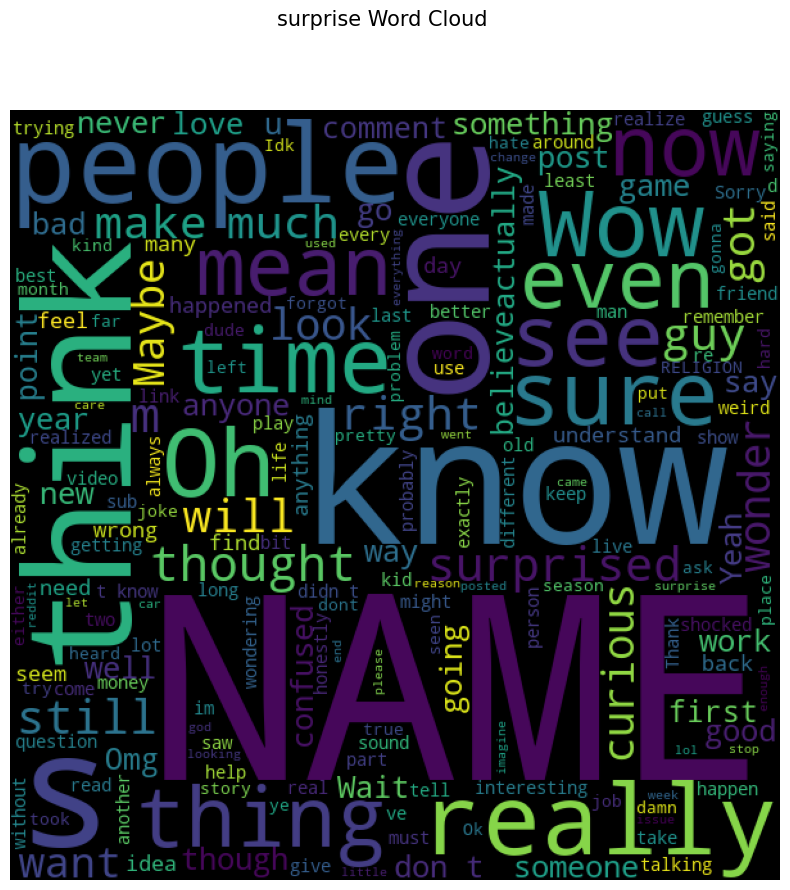

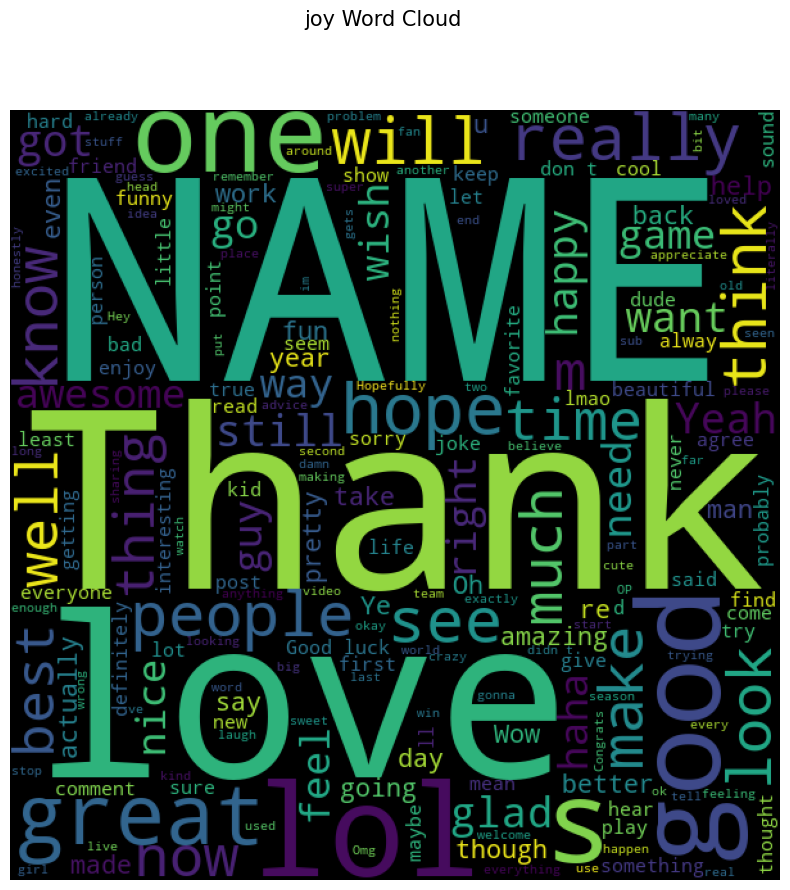

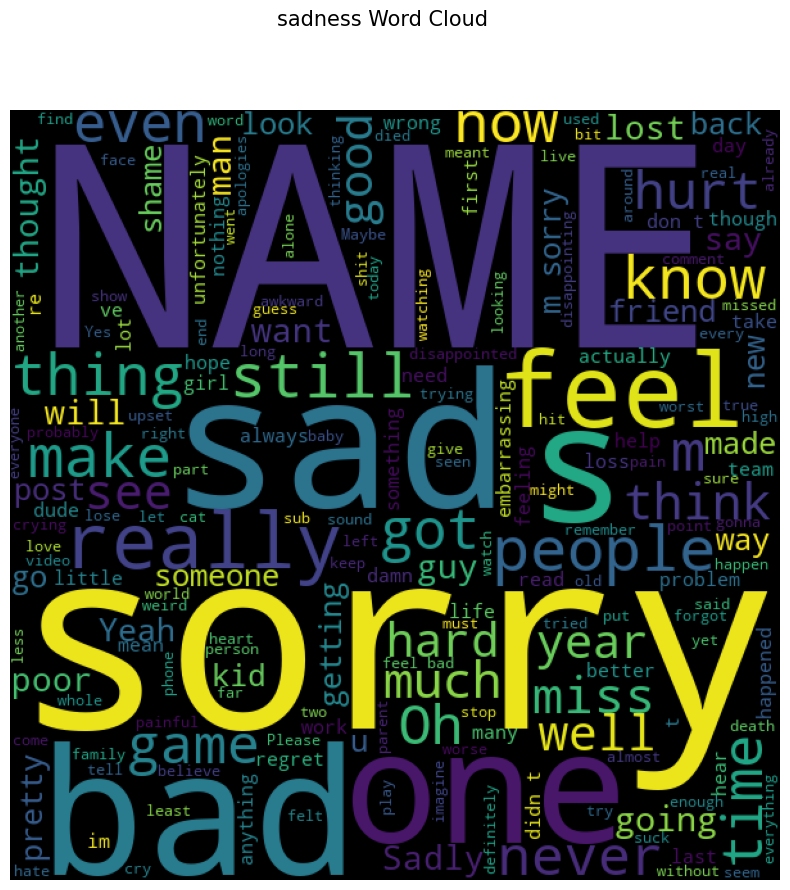

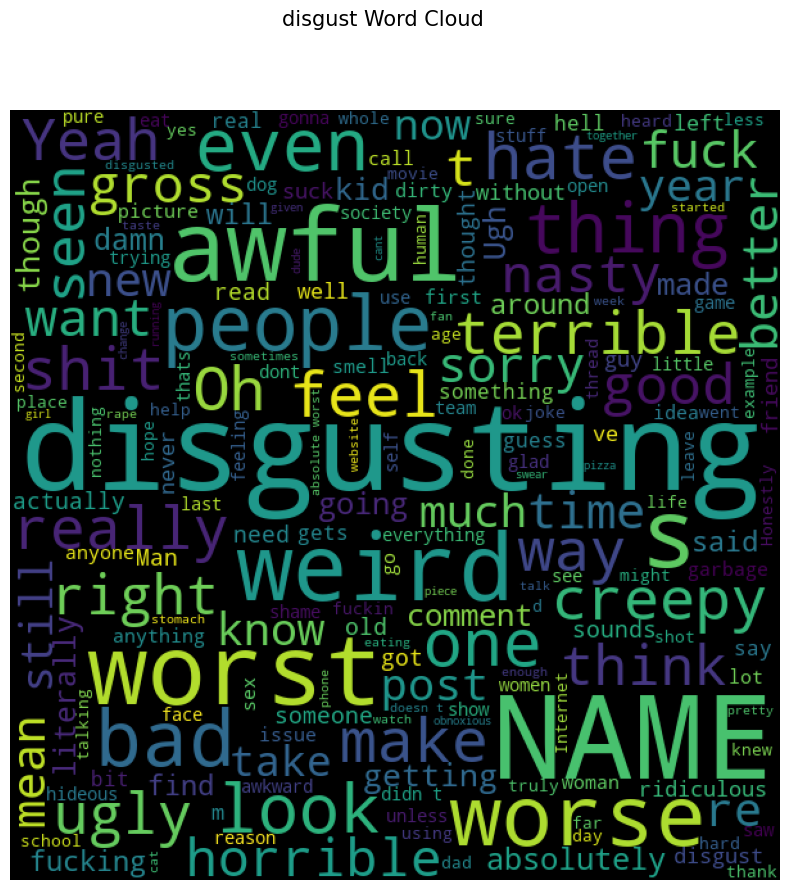

In [24]:
for emotion in emotion_list:
    text = " ".join([sentence for sentence in train_data.loc[train_data["Emotion"] == emotion, "Comment"]])
    wordcloud = WordCloud(width=600, height=600).generate(text)
    word_cloud(wordcloud, emotion)

In [ ]:
train_data["Emotion"] = train_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
test_data["Emotion"] = test_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
val_data["Emotion"] = val_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})

In [26]:
# Check for null values
print("Train data:", train_data.isnull().sum())

print("Test data:", test_data.isnull().sum())

print("Validation data:", val_data.isnull().sum())

Train data: Comment    0
Emotion    0
dtype: int64
Test data: Comment    0
Emotion    0
dtype: int64
Validation data: Comment    0
Emotion    0
dtype: int64


In [27]:
# Check duplicated values
print("Train data:", train_data.duplicated().sum())

print("Test data:", test_data.duplicated().sum())

print("Validation data:", val_data.duplicated().sum())

Train data: 152
Test data: 6
Validation data: 3


In [28]:
#Removing Duplicated values
index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis=0, inplace=True)
train_data.reset_index(inplace=True, drop=True)

index = test_data[test_data.duplicated() == True].index
test_data.drop(index, axis=0, inplace=True)
test_data.reset_index(inplace=True, drop=True)

index = val_data[val_data.duplicated() == True].index
val_data.drop(index, axis=0, inplace=True)
val_data.reset_index(inplace=True, drop=True)

In [29]:
#print rows which are duplicated in the text but the same emotion
train_data[train_data["Comment"].duplicated() == True]

Comment  Emotion
6610                                     My man!        3
7925                           What do you mean?        5
8344                         Weird flex but okay        3
8978                                      [NAME]        6
9375                                    Grow up.        0
9481                           Weird flex but ok        1
14012                             You're welcome        6
14104                           This is horrible        2
15809                                    Lol no.        3
20768                                Oh boy yeah        3
20785                                    [NAME]!        6
20866                          Weird flex but ok        0
22881  A surprise to be sure, but a welcome one.        5
23704                I feel personally attacked.        4
24105                          Weird flex but ok        3
24275                               I don't know        5
25076                    That escalated quickly.        5
25353                                    Yes!!!!        3
28886                            Cheers, [NAME]!        6
29036                       He looks like [NAME]        3
31980                     That's how mafia works        5
32741                                 Calm down.        6
37293                              Amen to that!        6
37578                        Underrated comment.        6
39357                               OH MY [NAME]        5
39710                         Not even slightly.        6
39842                             cool story bro        3
40217                      You can't be serious.        6
40670                           What did he say?        5
40894                                 Please no.        0
41542                        This hurts my brain        4

In [30]:
#print rows which are duplicated in the text but the same emotion
test_data[test_data["Comment"].duplicated() == True]

Empty DataFrame
Columns: [Comment, Emotion]
Index: []

In [31]:
#print rows which are duplicated in the text but the same emotion
val_data[val_data["Comment"].duplicated() == True]

Empty DataFrame
Columns: [Comment, Emotion]
Index: []

In [32]:
# Removing the duplicate text
index = train_data[train_data["Comment"].duplicated() == True].index
train_data.drop(index, axis=0, inplace = True)
train_data.reset_index(inplace=True, drop=True)

In [33]:
val_data = val_data.drop([22, 23])

# Data Visualising and Analysis

In [34]:
X = train_data["Comment"]

In [35]:
lst = []
for i in X:
    lst.append(len(i))
    
len1 = pd.DataFrame(lst)
len1.describe()

0
count  43227.000000
mean      68.630694
std       36.625139
min        2.000000
25%       38.000000
50%       65.000000
75%       96.000000
max      703.000000

In [36]:
cts = []
for i in range(7, 301):
    ct=0
    for k in lst:
        if k==i:
            ct+=1
    cts.append(ct)

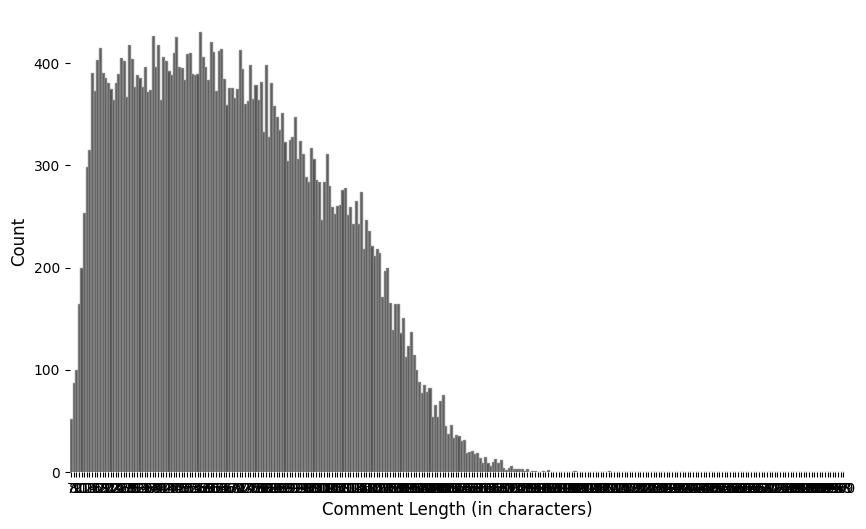

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(7, 301)), y=cts, color="#4C4C4C", edgecolor="grey")

# Set axis labels
plt.xlabel("Comment Length (in characters)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Remove gridlines for a cleaner look
sns.despine(left=True, bottom=True)

# Save the plot with data labels
plt.savefig("comment_length_distribution.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

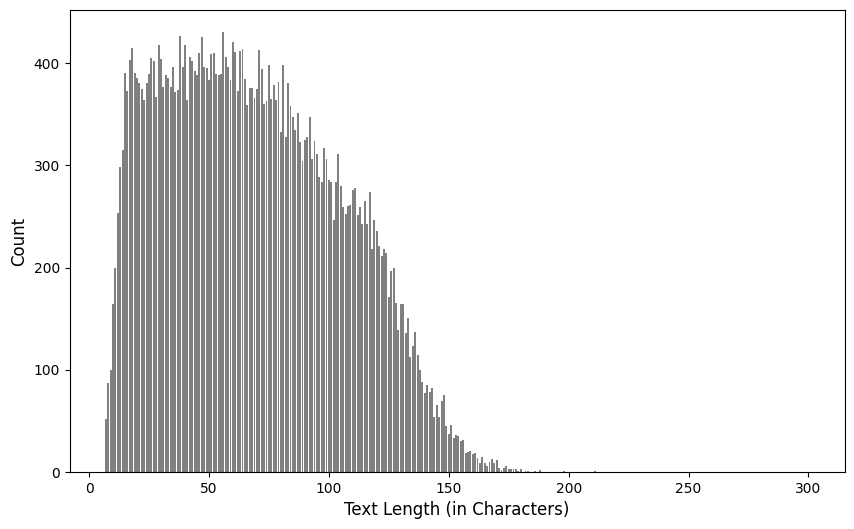

In [38]:
plt.figure(figsize=(10, 6))  # Adjust the size if necessary
plt.bar(range(7, 301), cts, color='grey')

# Customize the plot
plt.xlabel('Text Length (in Characters)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Save and show the plot
plt.savefig("comment_length_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

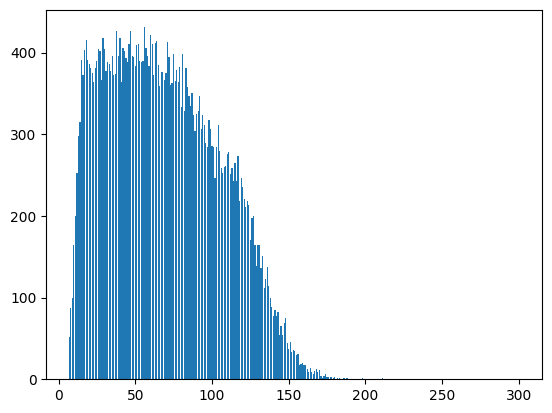

In [39]:
plt.bar(range(7, 301), cts)
plt.show()

<Axes: xlabel='Emotion', ylabel='count'>

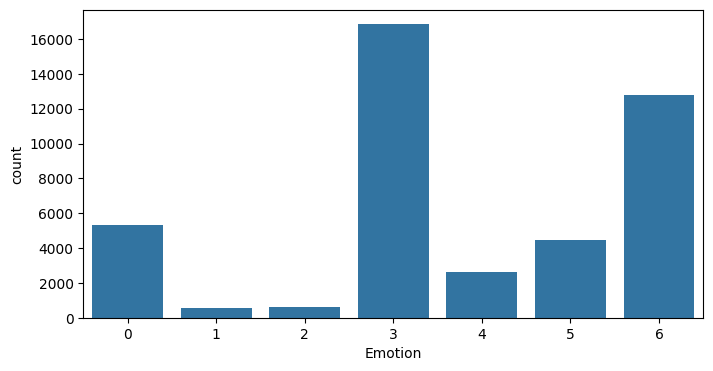

In [40]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=train_data)

<Axes: xlabel='Emotion', ylabel='count'>

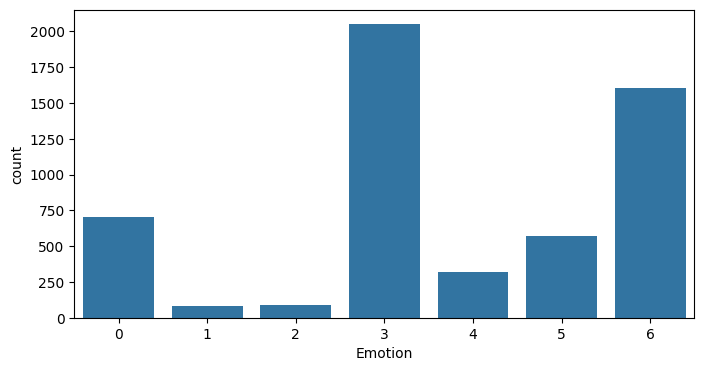

In [41]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=test_data)

<Axes: xlabel='Emotion', ylabel='count'>

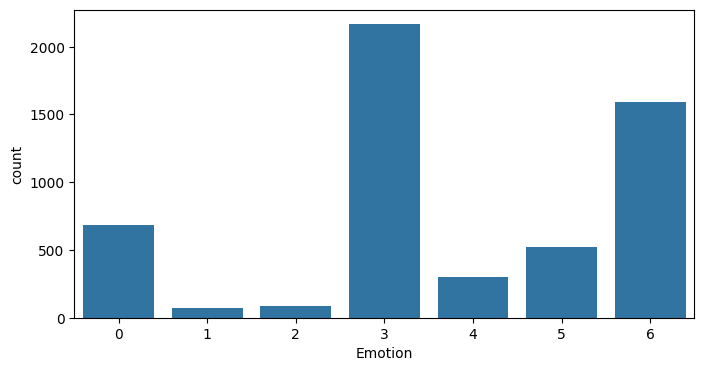

In [42]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=val_data)

# Data Cleaning

In [43]:
train_data["Length"] = [len(x) for x in train_data["Comment"]]

In [44]:
print(len(stopwords))

# Max length of senetence
max_len = train_data["Length"].max()
print(max_len)

179
703


In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)

In [46]:
vocabsize = 18000   #20-12551 #30-15000 43-17555
vocabsize = int(vocabsize * 5 )
print(vocabsize)

90000


In [47]:
def text_cleaning(df, column):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    # Split each sentence into a list of words and flatten the list of lists into a single list
    words = [word.lower() for sentence in corpus for word in nltk.word_tokenize(sentence)]

    # Convert the list of words into a set to remove duplicates and find the number of unique words
    unique_words = set(words)
    num_unique_words = len(unique_words)

    print(f"Number of unique words: {num_unique_words}")
    one_hot_word = [one_hot(input_text=word, n=vocabsize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    print(pad.shape)
    return pad

In [48]:
X_train = text_cleaning(train_data, "Comment")
X_test = text_cleaning(test_data, "Comment")
X_val = text_cleaning(val_data, "Comment")

Number of unique words: 17555
(43227, 703)
Number of unique words: 6167
(5421, 703)
Number of unique words: 6237
(5421, 703)


In [49]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = val_data["Emotion"]

In [50]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [51]:
smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

In [52]:
smote = SMOTE(sampling_strategy='minority')
X_test, y_test = smote.fit_resample(X_test, y_test)
y_test.shape

(7386, 7)

In [53]:
smote = SMOTE(sampling_strategy='minority')
X_val, y_val = smote.fit_resample(X_val, y_val)

# Model Creation

In [54]:
model = Sequential()
model.add(Embedding(input_dim=vocabsize, output_dim=300, input_length=max_len))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(60, activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(7, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 703, 300)          27000000  
                                                                 
 dropout (Dropout)           (None, 703, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 703, 512)          1665024   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 60)                15420     
                                                                 
 dropout_2 (Dropout)         (None, 60)                0

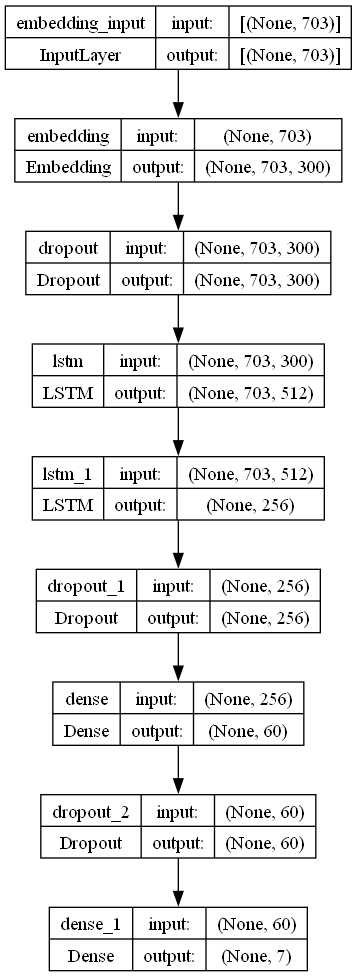

In [56]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='ter_architecture.png', show_shapes=True, show_layer_names=True)

In [53]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [54]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [55]:
from tensorflow.keras.callbacks import Callback

class BatchMetrics(Callback):
    def on_train_begin(self, logs=None):
        self.batch_accuracy = []
        self.batch_loss = []

    def on_batch_end(self, batch, logs=None):
        self.batch_accuracy.append(logs.get('accuracy'))
        self.batch_loss.append(logs.get('loss'))

# Initialize the callback
batch_metrics = BatchMetrics()

# Modify your model fit call to include the batch_metrics callback
hist = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=[callback, batch_metrics])

Epoch 1/3
1859/1859 [==============================] - 429s 228ms/step - loss: 1.2590 - accuracy: 0.5118 - val_loss: 0.9409 - val_accuracy: 0.6676
Epoch 2/3
1859/1859 [==============================] - 427s 230ms/step - loss: 0.9209 - accuracy: 0.6707 - val_loss: 0.8765 - val_accuracy: 0.6830
Epoch 3/3
1859/1859 [==============================] - 431s 232ms/step - loss: 0.8075 - accuracy: 0.7089 - val_loss: 0.8689 - val_accuracy: 0.6937


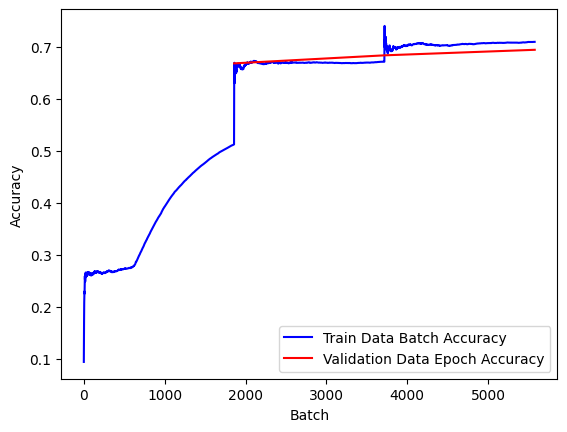

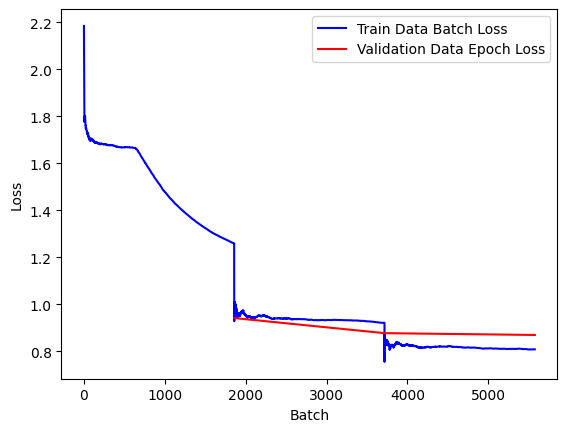

In [56]:
# Plotting batch accuracy
plt.plot(batch_metrics.batch_accuracy, "b", label="Train Data Batch Accuracy")
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting batch loss
plt.plot(batch_metrics.batch_loss, "r", label="Train Data Batch Loss")
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
# Save the model weights
model.save_weights('TER_custom_model.h5')

In [57]:
model.evaluate(X_test, y_test)

231/231 [==============================] - 18s 77ms/step - loss: 0.9034 - accuracy: 0.6809


[0.9033939838409424, 0.6808827519416809]

In [58]:
pred = model.predict(X_test)

231/231 [==============================] - 17s 73ms/step


In [59]:
pred_2 = model.predict(X_test)

231/231 [==============================] - 17s 72ms/step


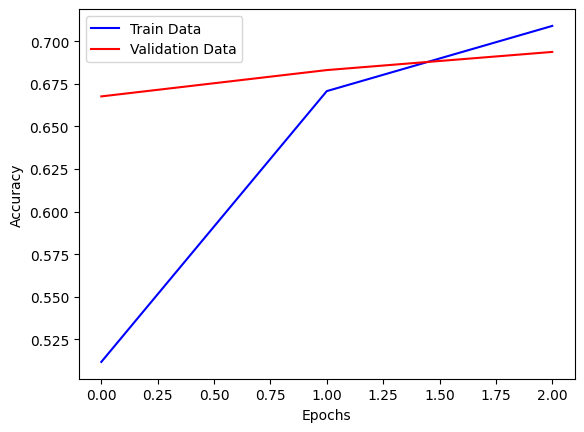

In [60]:
plt.plot(hist.history["accuracy"], "b", label="Train Data")
plt.plot(hist.history["val_accuracy"], "r", label="Validation Data")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

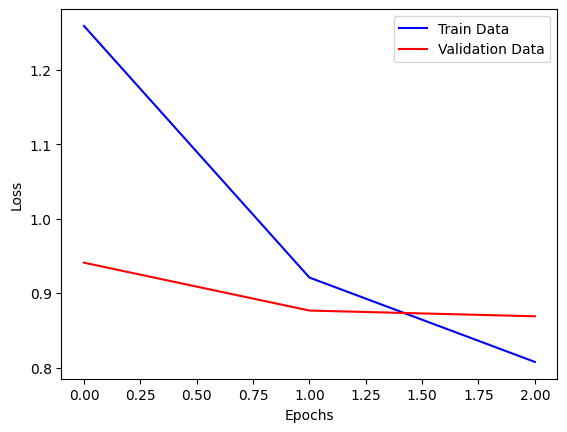

In [61]:
plt.plot(hist.history["loss"], "b", label="Train Data")
plt.plot(hist.history["val_loss"], "r", label="Validation Data")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
y_pred = pred.argmax(axis=-1)
y_test = y_test.argmax(axis=-1)

In [63]:
y_test.shape

(7386,)

In [64]:
y_pred.shape

(7386,)

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, save_path=None):
    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a heatmap of the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
    
    # Label the plot
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    # Show the plot
    plt.show()


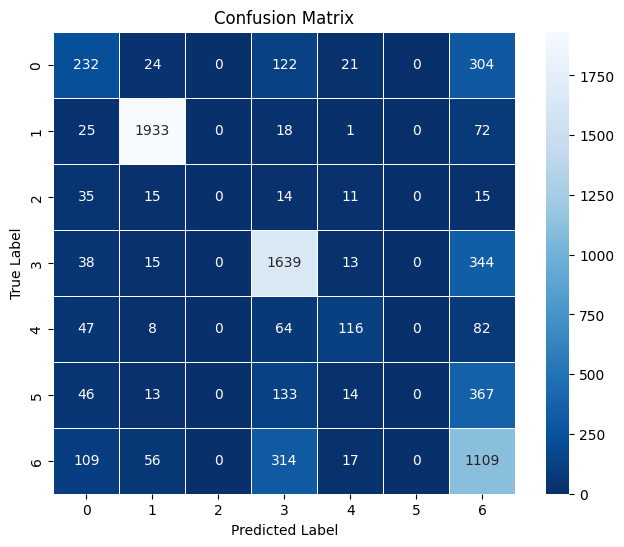

In [66]:
plot_confusion_matrix(y_test, y_pred, save_path='confusion_matrix_TER_custom.png')

In [67]:
print(classification_report(y_test, y_pred, zero_division='warn'))

              precision    recall  f1-score   support

           0       0.44      0.33      0.38       703
           1       0.94      0.94      0.94      2049
           2       0.00      0.00      0.00        90
           3       0.71      0.80      0.75      2049
           4       0.60      0.37      0.45       317
           5       0.00      0.00      0.00       573
           6       0.48      0.69      0.57      1605

    accuracy                           0.68      7386
   macro avg       0.45      0.45      0.44      7386
weighted avg       0.63      0.68      0.65      7386



C:\Users\mafaz\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mafaz\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mafaz\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

# Print the results
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Accuracy:  0.6808827511508259
Precision:  0.45266784418358924
Recall:  0.4471714236679161
F1-score:  0.44180151432079223


C:\Users\mafaz\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
# Step 1: Preprocess the Input Sentence
def preprocess_sentence(sentence):
    stemmer = PorterStemmer()
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = sentence.lower()
    sentence = sentence.split()
    sentence = [stemmer.stem(word) for word in sentence if word not in stopwords]
    sentence = " ".join(sentence)
    return sentence

# Step 2: Convert the Sentence
def convert_sentence(sentence):
    processed_sentence = preprocess_sentence(sentence)
    one_hot_sentence = [one_hot(input_text=processed_sentence, n=vocabsize)]
    padded_sentence = pad_sequences(sequences=one_hot_sentence, maxlen=max_len, padding="pre")
    return padded_sentence

# Step 3: Predict the Sentiment
def predict_sentiment(sentence):
    processed_sentence = convert_sentence(sentence)
    prediction = model.predict(processed_sentence)
    predicted_class = prediction.argmax(axis=-1)[0]
    return predicted_class

# Step 4: Map the Predicted Class
def map_predicted_class(predicted_class):
    emotion_mapping = {0: "anger", 1: "disgust", 2: "fear", 3: "joy", 4: "sadness", 5: "surprise", 6: "neutral"}
    return emotion_mapping[predicted_class]

# Example Usage
new_sentence = "I am feeling very happy today!"
predicted_class = predict_sentiment(new_sentence)
predicted_emotion = map_predicted_class(predicted_class)

print(f"The sentiment of the sentence is: {predicted_emotion}")


1/1 [==============================] - 0s 306ms/step
The sentiment of the sentence is: joy
